# Bank Client Churn Modeling Project - Lin Han

__The 'Bank client churn modeling project' aims to help a European bank identify and forecast if its client has the intend to leave the bank or continue to stay. Additionally, the model can tell bank what types of clients are likely to churn, including their demographic characteristics, estimated income levels and financial product preference. etc. Therefore, banks can provide better services to retain those clients in advance for maintaining and increasing the future revenues and profits.__

__First, I explored the dataset “Client_Churn_Dataset” acquired from Kaggle website, visualized variables and did correlation analysis to check if the assumptions of logistic regression model are met. Then, I applied one-hot encoding to get dummy variables and split training and testing datasets. Next, I developed a logistic regression model and the final test accuracy is 81.5%. I used Scikit-learn and Statsmodels packages to improve the predictive accuracy and enhance the interpretability of my model. Finally, I created two random forest non-parameter models using different varibles (the higher test accuracy is 86.85%) to compare with the logistic regression model and ranked the importance of each independent variables. The top 5 most important variables are 'Age', 'Estimated Salary', 'Balance', 'Credit Score' and 'Number of Products'.__

__Key findings & Recommendations from logistic regression model: (1) The more active the client is, the less likely he/she will leave the bank. Therefore, bank should apply business strategies, such as creative marketing and product innovation to activate more clients. (2) Clients in the 'Germany' market have higher probability to close the bank account, so bank should provide more attractive retention offers and better services to those clients, even conducting a client survey and research to hear their needs and requirements. (3) Bank ought to pay more attention to senior and elder customers, because they are more likely to churn than young people, the reasons behind should be further investigated. Bank should offer more targeting offers to make them more active and satisfied. (4) Other factors Gender, Number of products owned, Have credit card or not also can impact the probability to churn for clients.__

## 1. Import packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data preprocessing functions
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Fit classification models
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

# Functions to evaluate classification model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score

In [2]:
# Set the style of plot
plt.style.use('ggplot')

## 2. Check original dataset and remove irrelevant feature

### 2.1. Import original Client_Churn_Dataset as a dataframe df_original

* The dataset “Client_Churn_Dataset” is acquired from Kaggle website: https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers. 
* It contains detailed information of 10,000 customers of a European bank and 14 variables, including 13 independent variables and 1 binary dependent variable 'Exited' that records if a bank client churn or not churn.

In [3]:
# Load Client_Churn_Dataset from local folder
df_original = pd.read_csv('C:/Users/han_l/Desktop/Multivariate_Project/Client_Churn_Dataset.csv')

In [4]:
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Check if the dataset size is sufficient to build model: df_original has 10000 observations and 14 columns
df_original.shape

(10000, 14)

### 2.2. Check original dataset missing values & duplicate records

In [6]:
# Check if missing values exist and column types
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
# Check if duplicate rows exist based on unique 'CustomerId' column
df_duplicate = df_original[df_original.duplicated(['CustomerId'])]
print(df_duplicate)

Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []


### 2.3. Remove irrelevant independut variables & Create a new dataframe df

In [8]:
# Remove 3 features that have no impact on the churn probability, because they are specific to a client
df = df_original.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [9]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 3. Explore variables and correlation analysis

### 3.1. Explore target variable 'Exited'

* The dependent variable 'Exited' is binary indicating whether the client decided to leave the bank or not leave (0 means not churn and 1 means churn).
* 79.6% bank clients did not churn, while 20.4% clients left the bank, so the reasons behind should be carefully investigated for the bank to retain clients.
* On average, clients exited have slightly lower credit score, larger age, higher balance, less active and higher estimated salary than clients continue to stay in the bank. 

In [10]:
# Overview of client chrun or not churn: seems clients have older age, higher balance and estimate salary tend to leave
df.groupby('Exited').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


In [11]:
# Check target variable 'Exited' is binary & how many clients churned and not churn
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

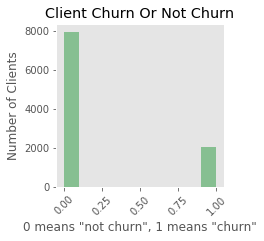

In [12]:
df.hist(column='Exited', grid=False, xrot = 45, figsize=(3,3), color='#86bf91')
plt.title('Client Churn Or Not Churn')
plt.xlabel('0 means "not churn", 1 means "churn"')
plt.ylabel('Number of Clients')
plt.show()

### 3.2. Explore and visualize  2 categorical independent variables 'Geography' and 'Gender'

* The bank has 3 target markets, including France, Spain, and Germany.
* Half of the clients were from France (50.14%), and 25.09% were from Germany, 24.77% were from Spain. 
* Germany has the highest churn rate (32.44% exited) and highest balance (119730) among the 3 regions, while France where the major clients come from has the lowest churn rate (16.15% exited) and Spain has a similar churn rate (16.67% exited).
* The bank has more male clients (54.57%) than female clients (45.43%). 
* Female has a higher churn rate 25.1% than that of male 16.5%. 

In [13]:
# Calculate categorical means for 'Geography'
df.groupby('Geography').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,
France,649.668329,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548
Germany,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Spain,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734


In [14]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

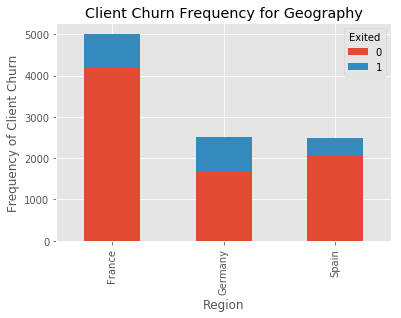

In [15]:
# Visualize the independent varible 'Exited' by 3 regions
pd.crosstab(df.Geography, df.Exited).plot(kind='bar', stacked=True)
plt.title('Client Churn Frequency for Geography')
plt.xlabel('Region')
plt.ylabel('Frequency of Client Churn')
plt.show()

In [16]:
# Calculate categorical means for 'Gender'
df.groupby('Gender').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Gender,,,,,,,,,
Female,650.831389,39.238389,4.966102,75659.369139,1.544134,0.702619,0.502751,100601.541382,0.250715
Male,650.276892,38.658237,5.051677,77173.974506,1.518600,0.707898,0.525380,99664.576931,0.164559


In [17]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

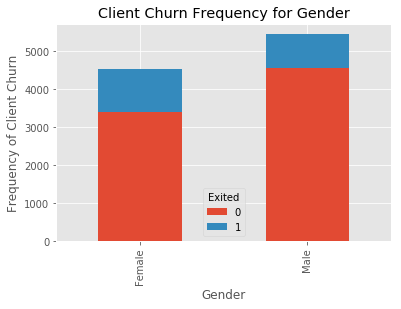

In [18]:
# Visualize the independent varible 'Exited' by 'Gender'
pd.crosstab(df.Gender, df.Exited).plot(kind='bar', stacked=True)
plt.title('Client Churn Frequency for Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency of Client Churn')
plt.show()

### 3.3. Explore and visualize the rest 9 continuous variables

* The clients' age group is mainly from 25 to 50 years old, and the average age is 38.9 years old. 
* Older customers seem more likely to churn than the younger clients, while other variables seem not significantly affect the likelihood to churn. 
* The reasons of why older clients tend to close the bank account can be: (1) They may have more considerations and higher standards for products and services when they choose a bank. (2) They always have a higher level of salaries and savings, so that the competitors would like to win this group of clients. Additionally, for those clients elder than 75 years old, the reasons behind need to be further investigated (considering the health care issues. etc.)
* Credit score is mainly ranging from 550 to 750, and the average score is 650.5.
* Tenure is mainly ranging from 2 to 8 years, and the average tenure is 5 years.
* There is a huge number of zero (0) balance clients (more than 35%), and the mean of balance is 76,485 euro (I assume the European bank use euro for clients balance and esrimated salary).
* Most clients have 1 or 2 products, and the average number of products is 1.53, but more details of products are not given in the dataset.
* Around 70% of clients had at least 1 credit card.
* Slightly more than half of the clients (51.51%) are active members. 
* Estimated salary is mainly ranging from €42,580 to €157,600, and the average estimated salary is €100,090.
* As mentione before, 79.6% bank clients continue to stay, while 20.37% clients left the bank.

In [19]:
# Explore the rest 9 continuous variables, including 8 input variables and 1 target variable 'Exited'
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


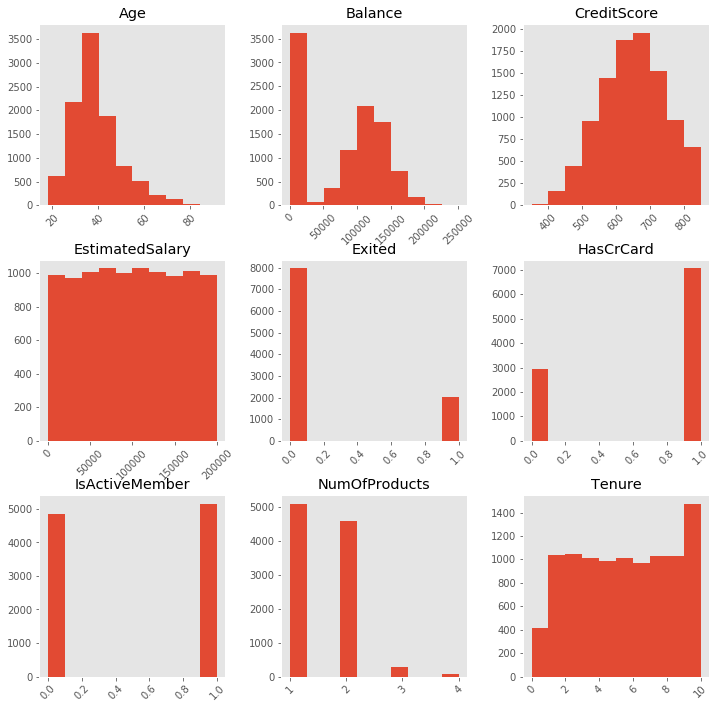

In [20]:
# Visualize 9 continuous variables using histogram
df.hist(grid=False, xrot = 45, figsize=(12,12))
plt.show()

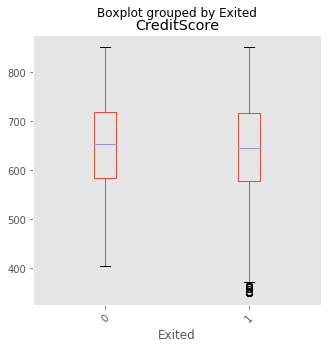

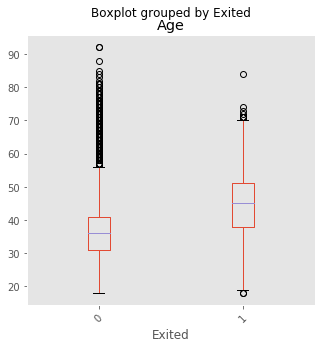

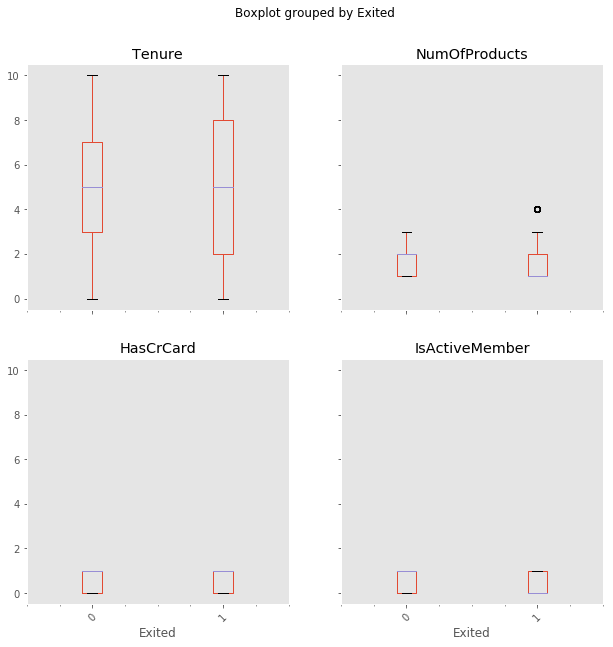

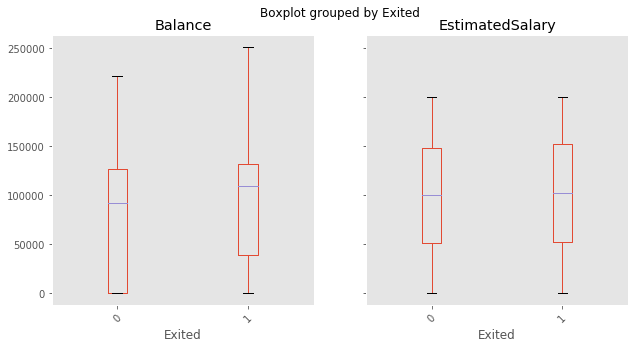

In [21]:
# Visualize 9 variables using boxplot
df.boxplot(column = ['CreditScore'], by = 'Exited', rot = 45, grid=False, figsize=(5,5))
df.boxplot(column = ['Age'], by = 'Exited', rot = 45, grid=False, figsize=(5,5)) 
df.boxplot(column = ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], by = 'Exited', rot = 45, grid=False, figsize=(10,10))
df.boxplot(column = ['Balance', 'EstimatedSalary'], by = 'Exited', rot = 45, grid=False, figsize=(10,5))
plt.show()

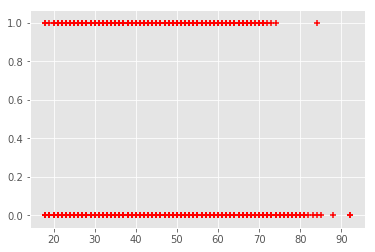

In [22]:
# Explore 'Age' variable: seems clients > 75 yrs old tend to churn, but the reasons need to be further investigated
plt.scatter(df.Age, df.Exited, marker='+', color='red')
plt.show()

### 3.4. Correlation analysis on independent variables

* As shown in the below correlation graph, none of the 8 independent continuous variables has a strong correlation with each other. That means there is no significant collinearty, so the assumption of logistic regression model is met. 

In [23]:
# correlation analysis on variables, delete the target variable 'Exited'
df_corr = df.drop('Exited', 1)

In [24]:
# visualize correlation analysis plot: predictors are independent of each other
corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1,-0.004,0.00084,0.0063,0.012,-0.0055,0.026,-0.0014
Age,-0.004,1,-0.01,0.028,-0.031,-0.012,0.085,-0.0072
Tenure,0.00084,-0.01,1,-0.012,0.013,0.023,-0.028,0.0078
Balance,0.0063,0.028,-0.012,1,-0.3,-0.015,-0.01,0.013
NumOfProducts,0.012,-0.031,0.013,-0.3,1,0.0032,0.0096,0.014
HasCrCard,-0.0055,-0.012,0.023,-0.015,0.0032,1,-0.012,-0.0099
IsActiveMember,0.026,0.085,-0.028,-0.01,0.0096,-0.012,1,-0.011
EstimatedSalary,-0.0014,-0.0072,0.0078,0.013,0.014,-0.0099,-0.011,1


## 4. Convert categorical variables to dummy variables

* Data transformation, using one-hot encoding for 'Geography' (France, Germany, Spain) and 'Gender'(Female, Male) to convert categorical variables to dummy variables for the logistic regression model building.

In [25]:
# Represent “n” categories with “n - 1” columns, so start from 1 st column
Geography_new = pd.get_dummies(df_original.Geography).iloc[:,1:]
Gender_new = pd.get_dummies(df_original.Gender).iloc[:,1:]

# Concatenate horizontally df and 'Geography_new' and 'Gender_new' dataframes 
df = pd.concat([df, Geography_new, Gender_new], axis=1)

# Drop original 'Geography' and 'Gender'
df = df.drop(columns=['Geography', 'Gender'])

In [26]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [27]:
df.shape

(10000, 12)

## 5. Split training and testing datasets 

* First, I isolated 11 independent variables to X dataset and 1 target variable 'Exited' to y dataset from df. 
* Then, I split dataset by using function train_test_split(), so the X, y datasets are broken into two parts in a ratio of 80:20, which means 80% data will be used for model training and 20% for model testing. 
* Additionally, I set random_state equal to 2, which is the seed used by the random number generator to select records randomly. 

In [28]:
# Isolate independent variables to X dataset and target variable to y dataset from df
X = df.drop(columns = ['Exited'])
y = df['Exited']

In [29]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [30]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [31]:
# Split training and testing datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

## 6. Build and evaluate logistic model using Scikit-learn package

* First, I applied sklearn package to build a logistic model using training data to fit it, and select the 'lbfgs' solver because it performs better for larger datasets, and I set max_iter to 500 to achieve better predictive accuracy. 
* Then, I printed the model coefficients for all 11 input variables and found: 
* (1) 'Age' has greatest impact to the response variable 'Exited', because the coefficient is 0.045 that means the higher the age, the more likely the client will churn. 
* (2) The higher the credit score (coefficient: -0.0051), the longer the tenure (coefficient: -0.0016), the client is an active member (coefficient: -0.0014), or the gender is male (coefficient: -0.0011), the client has lower probability to churn. 
* (3) 'Balance' (coefficient: 3.52594725e-06) and 'EstimatedSalary' (coefficient: -1.04331422e-06) almost have no impact to 'Exited', because th coefficients are too small. 
* Lastly, I evaluated my model by using classification report, confusion matrix and ROC curve. My model reached a classification rate of 79.95%, which considered as good accuracy using the test dataset. However, based on the classification report, my model has low precision 0.3125 (indicating accuracy of positive predictions of client churn) and recall 0.0392 (indicating the ability of a classifier to find all positive instances client churn). So, I plan to improve my regression model by variable selection. 

In [32]:
# Created a Logistic Regression classifier object using LogisticRegression() function
# Built the model and specified a solver 'lbfgs') and set max_iter to 500
log_reg = LogisticRegression(solver='lbfgs', max_iter=500)

# Fit the model with training dataset using fit() 
log_reg.fit(X_train, y_train)

# Perform prediction on the test dataset using predict()
y_pred = log_reg.predict(X_test)

In [33]:
# Print Logistic Model 11 Coefficients: 
# CreditScore, Age, Tenure, 
# Balance, NumOfProducts, HasCrCard, 
# IsActiveMember, EstimatedSalary, Germany, 
# Spain, Male

log_reg.coef_

array([[-5.11879057e-03,  4.48020903e-02, -1.61850835e-03,
         3.52594725e-06, -4.41863325e-04, -1.88557714e-04,
        -1.36405189e-03, -1.04331422e-06,  9.58394929e-04,
        -3.42199992e-04, -1.07969630e-03]])

In [34]:
# Print confusion matrix: Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions
# In the output, 1584 (TP / True Positive) and 15 (TN / True Negative) are actual and correct predictions, 
# while 33 (FN / False Negative) and 368 (FP / False Positive) are incorrect predictions.
# Detailed explanation: 
# TP / True Positive: when a case was actually positive and predicted positive
# TN / True Negative: when a case was actually negative and predicted negative
# FN / False Negative: when a case was actually positive but predicted negative
# FP / False Positive: when a case was actually negative but predicted positive

print(confusion_matrix(y_test, y_pred))

[[1584   33]
 [ 368   15]]


In [35]:
# Accuracy: a classification rate 
print("Accuracy:",accuracy_score(y_test, y_pred))

# Precision is the accuracy of positive predictions: the ability not to label an instance positive that is actually negative. 
# Precision formula = TP/(TP + FP)
print("Precision:", precision_score(y_test, y_pred))

# Recall is the ability of a classifier to find all positive instances: Recall formula = TP/(TP+FN)
# In binary classification, recall of the positive class is known as “sensitivity”; recall of the negative class is “specificity”.
print("Recall:", recall_score(y_test, y_pred))

# A more detail text report showing the main classification metrics
print(classification_report(y_test, y_pred))  

Accuracy: 0.7995
Precision: 0.3125
Recall: 0.0391644908616188
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1617
           1       0.31      0.04      0.07       383

   micro avg       0.80      0.80      0.80      2000
   macro avg       0.56      0.51      0.48      2000
weighted avg       0.72      0.80      0.73      2000



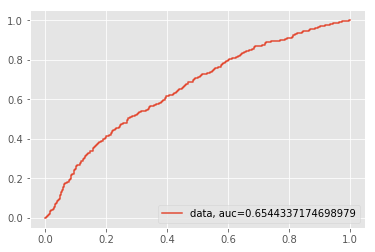

In [36]:
# Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. 
# It shows the tradeoff between sensitivity and specificity.

y_pred_proba = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## 7.  Improve the logistic model using 'statsmodels' to select independent variables 

* First, I build a new logistic regression model using another package 'statsmodels' to identify not significant independent variables. 
* Then, I dropped the 3 not significant 'Balance', 'EstimatedSalary' and 'Spain' because their p-value is larger than 0.05. That also indicates bank should consider less the clients account balance, future income and whether they come from Spain or France when predicting the probability to churn. 
* Finally, I used the rest 9 variables to fit my logistic regression model built in Scikit-learn again, and improved the classification accuracy rate to 81.5%.  
* From the new classification report, my model has higher precision 0.5537, which means when my Logistic Regression model predicted clients are going to leave the bank, that clients will churn 55.4% of the time. My model also have a higher recall 0.1749, which indicates the ability of finding clients will churn. For example, for clients who have churned in the test dataset, my regression model can identify them 17.5% of the time.
* Key findings from the model coefficients of 8 input variables: 
* (1) 'IsActiveMember' has greatest influence to the target variable 'Exited', because the coefficient is -1.0181. That means the more active the client is, the less likely he/she will churn. 
* (2) The 2 variables 'Germany' and 'Age' may cause clients to close the bank account, especially when clients are from Germany (coefficient: 0.9035) and have larger age (coefficient: 0.0725). 
* (3) If the client gender is male (coefficient: -0.57601), the more number of products owned (coefficient: -0.1574), the client has credit card (coefficient: -0.1041), and the longer the tenure (coefficient: -0.0197), the client has lower probability to churn. 
* (4) The credit score (coefficient: -8.47832261e-04) has the least impact to 'Exited', because the coefficient is too small. 

### 7.1. Build logistic regression model using statsmodels package

In [37]:
# Fit the logistic model using another package 'statsmodels', using maximum likelihood 
logit_model=sm.Logit(y_train, X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.439147
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.138      
Dependent Variable: Exited           AIC:              7048.3464  
Date:               2020-05-17 22:39 BIC:              7125.2055  
No. Observations:   8000             Log-Likelihood:   -3513.2    
Df Model:           10               LL-Null:          -4076.9    
Df Residuals:       7989             LLR p-value:      6.0574e-236
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
CreditScore       -0.0036   0.0002 -17.2181 0.0000 -0.0041 -0.0032
Age                0.0595   0.0026  22.9431 0.0000  0

In [38]:
# p-values for most of the variables are smaller than 0.05, and drop not significant variables
X_new = X_train.drop(['Balance', 'EstimatedSalary', 'Spain'], axis=1)
y_new = y_train

In [39]:
logit_model_new=sm.Logit(y_new, X_new)
result_new=logit_model_new.fit()
print(result_new.summary2())

Optimization terminated successfully.
         Current function value: 0.439349
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.138      
Dependent Variable: Exited           AIC:              7045.5765  
Date:               2020-05-17 22:39 BIC:              7101.4741  
No. Observations:   8000             Log-Likelihood:   -3514.8    
Df Model:           7                LL-Null:          -4076.9    
Df Residuals:       7992             LLR p-value:      1.6271e-238
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
CreditScore       -0.0036   0.0002 -18.3223 0.0000 -0.0040 -0.0032
Age                0.0595   0.0026  23.1419 0.0000  0

In [42]:
# Improved Logistic Model Coefficients: 
logit_model_new.fit().params

Optimization terminated successfully.
         Current function value: 0.439349
         Iterations 6


CreditScore      -0.003616
Age               0.059522
Tenure           -0.043290
NumOfProducts    -0.339743
HasCrCard        -0.213317
IsActiveMember   -1.045285
Germany           0.865261
Male             -0.648398
dtype: float64

### 7.2. Improved logistic regression model in Scikit-learn using new training datasets 

In [43]:
# Fit logistic regression model again use X_new, y_new 
log_reg_new = LogisticRegression(solver='lbfgs', max_iter=500)
log_reg_new.fit(X_new, y_new)

# Drop 3 inputs from X_test to match the number of variables in X_new
X_test_new=X_test.drop(['Balance', 'EstimatedSalary', 'Spain'], axis=1)
y_pred_new = log_reg_new.predict(X_test_new)

In [44]:
# Improved Logistic Model Coefficients: 
# CreditScore, Age, Tenure, 
# NumOfProducts, HasCrCard, IsActiveMember, 
# Germany, Male

log_reg_new.coef_

array([[-8.47832261e-04,  7.24943096e-02, -1.96874154e-02,
        -1.57396549e-01, -1.04065327e-01, -1.01812087e+00,
         9.03489021e-01, -5.76013025e-01]])

In [45]:
print('Accuracy:', accuracy_score(y_test, y_pred_new))
print('Precision:', precision_score(y_test, y_pred_new))
print('Recall:', recall_score(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))  

Accuracy: 0.815
Precision: 0.5537190082644629
Recall: 0.17493472584856398
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1617
           1       0.55      0.17      0.27       383

   micro avg       0.81      0.81      0.81      2000
   macro avg       0.69      0.57      0.58      2000
weighted avg       0.78      0.81      0.77      2000



## 8. Build a random forest model to compare with logistic regression model

* I created a random forest non-parameter model (test accuracy is 86.85%) to compare with the parameter logistic regression model. I set number of parameters (the number of trees in the forest) to 400 based on trial-and-error and set random state to 2. 
* I split dataset by using the same ratio of 80:20, so 80% data will be used for model training and 20% for model testing. 
* Then, I generated classification report, which shows my model has higher precision 0.7536, which is much higher than my final Logistic Regression model (0.5537). Therefore, bank has more confidence when use the random forest model to predict if clients will leave the bank, and clients will churn 75.36% of the time. My model also has an increased recall 0.5210 than the recall in Logistic regression model 0.1749. For instance, for clients who have churned in the test dataset, my random forest model can identify them 52.10% of the time.
* I ranked the importance of 11 independent variables. The top 5 variables are 'Age', 'EstimatedSalary', 'Balance', 'CreditScore' and 'Number of Products'. 
* Additionally, I tried to fit the random forest model using selected 8 independent variables, but the test accuracy decreased to 85.5%. The top 4 variables are 'Age', 'CreditScore', 'Number of Products' and 'Tenure'. 
* To summarize the two models results, bank should pay more attention to 'Age', 'CreditScore' and 'Number of Products' to retain their clients. 

### 8.1. Develop a simple random forest model using all features

In [46]:
# Split training and testing datasets for random forest model
rf_X =  df.drop(['Exited'], axis=1)
rf_y = df['Exited']
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, rf_y, test_size = 0.2, random_state = 0)

In [47]:
# Fit random forest model: try different parameters and check model accuracy
# rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)  

rf_classifier = RandomForestClassifier(n_estimators=400, random_state=2)  
rf_classifier.fit(rf_X_train, rf_y_train)  
rf_predictions = rf_classifier.predict(rf_X_test)

In [48]:
print('Accuracy:', accuracy_score(rf_y_test, rf_predictions))
print('Precision:', precision_score(rf_y_test, rf_predictions))
print('Recall:', recall_score(rf_y_test, rf_predictions))
print(classification_report(rf_y_test, rf_predictions))  

Accuracy: 0.8685
Precision: 0.7535714285714286
Recall: 0.5209876543209877
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1595
           1       0.75      0.52      0.62       405

   micro avg       0.87      0.87      0.87      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



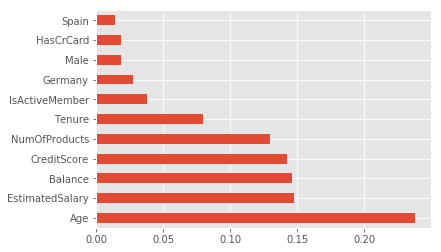

In [49]:
# Rank the importance of 11 independent variables
feat_importances = pd.Series(rf_classifier.feature_importances_, index=rf_X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

### 8.2. Explore the random forest model using selected features

In [50]:
# Drop 3 not significant variables and create new dataframs re_X_new
rf_X_train_new = rf_X_train.drop(['Balance', 'EstimatedSalary', 'Spain'], axis=1)

In [51]:
# Fit random forest model again
rf_classifier_new = RandomForestClassifier(n_estimators=400, random_state=2)  
rf_classifier_new.fit(rf_X_train_new, rf_y_train)  

# Drop 3 inputs from rf_X_test to match the number of variables in X_new
rf_X_test_new = rf_X_test.drop(['Balance', 'EstimatedSalary', 'Spain'], axis=1)
rf_predictions_new = rf_classifier_new.predict(rf_X_test_new)

In [52]:
print('Accuracy:', accuracy_score(rf_y_test, rf_predictions_new))
print('Precision:', precision_score(rf_y_test, rf_predictions_new))
print('Recall:', recall_score(rf_y_test, rf_predictions_new))
print(classification_report(rf_y_test, rf_predictions_new))  

Accuracy: 0.855
Precision: 0.6910299003322259
Recall: 0.5135802469135803
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1595
           1       0.69      0.51      0.59       405

   micro avg       0.85      0.85      0.85      2000
   macro avg       0.79      0.73      0.75      2000
weighted avg       0.84      0.85      0.85      2000



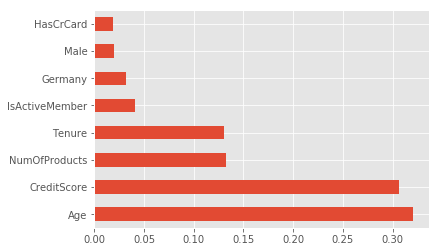

In [53]:
# Rank the importance of 8 independent variables
feat_importances = pd.Series(rf_classifier_new.feature_importances_, index=rf_X_train_new.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

## 9. Conclusion & Future Consideration

__In conclusion, my logistic regression model displayed a high accuracy of 81.5%, indicated that the relevant features could significantly influence clients in terms of whether leaving the bank or not. Based on the model result, we could offer valuable insights and practical recommendations for the bank to decrease the client churn rate, especially for clients non-active, have larger age, and come from Germany. 
Additionally, the model could also be applied to compute an individual’s probability and predict his/her intention to close the bank account given the relevant data inputs. Therefore, the bank could identify clients who are more likely to churn in advance. The corresponding departments would then take effective actions, such as providing appealing retention offers.__

__The future directions to improve my client churn models are collecting additional information of bank clients and conducting more predictive model comparisons and understanding the different model results. First, more information related to bank clients should be collected and added to the current dataset, such as the specific type of financial product clients owned and their preference of choosing those products. For model comparisons, I will further consider the trade-off of model accuracy and interpretability when I select predictive models. Although my logistic regression model has lower accuracy rate than random forest model, it can clearly explain and interpret the effects of independent variables by explicitly showing coefficients and corresponding p-values. Additionally, I want to find the deeper reasons why logistic regression model asks me to drop three less significant variables 'Balance', 'EstimatedSalary' and 'Spain', while random forest model shows 'Balance' and 'EstimatedSalary' are important features to make better prediction of client churn (Two types of models both indicate variable 'Spain' is not significant).__

Reference: 
* (1) Understanding Logistic Regression in Python: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
* (2) Building A Logistic Regression in Python, Step by Step: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
* (3) Explanations of parameters of sklearn.ensemble.RandomForestClassifier: https://blog.csdn.net/ustbbsy/article/details/79541546
* (4) sklearn.linear_model.LogisticRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* (5) Bank Customer Churn Prediction: https://www.kaggle.com/kmalit/bank-customer-churn-prediction/data

